# KWS Data Loader Design with Energy/Utterance Detector 

In [59]:
import numpy as np
import torch

import matplotlib.pyplot as plt

import scipy.io.wavfile as wav

import importlib
import librosa

import IPython
from scipy.io.wavfile import write
import librosa
import pytsmod as tsm
import soundfile as sf

import sys
import os

sys.path.append('../')
sys.path.append('../datasets')

from kws20 import KWS
import kws20

In [2]:
data_path = '/home/emretopcu/ai8x-training/data'

class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

simulate = False
args = Args(act_mode_8bit=simulate)

_, test_set = kws20.KWS_20_get_datasets((data_path, args), load_train=False, load_test=True)

Exception ignored in: <_io.FileIO name=65 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/home/emretopcu/ai8x-training/venv/lib/python3.8/site-packages/audioread/__init__.py", line 99, in available_backends
    if ffdec.available():
Exception ignored in: <_io.FileIO name=67 mode='rb' closefd=True>
Traceback (most recent call last):
  File "/home/emretopcu/ai8x-training/venv/lib/python3.8/site-packages/audioread/__init__.py", line 99, in available_backends
    if ffdec.available():


No key `stretch` in input augmentation dictionary! Using defaults: [Min: 0.8, Max: 1.3]
Processing the label: backward. 1 of 36
Finished in 0.352 seconds.
Processing the label: bed. 2 of 36
Finished in 0.315 seconds.
Processing the label: bird. 3 of 36
Finished in 0.320 seconds.
Processing the label: cat. 4 of 36
Finished in 0.316 seconds.
Processing the label: dog. 5 of 36
Finished in 0.331 seconds.
Processing the label: down. 6 of 36
Finished in 0.616 seconds.
Processing the label: eight. 7 of 36
Finished in 0.610 seconds.
Processing the label: five. 8 of 36
Finished in 0.632 seconds.
Processing the label: follow. 9 of 36
Finished in 0.248 seconds.
Processing the label: forward. 10 of 36
Finished in 0.244 seconds.
Processing the label: four. 11 of 36
Finished in 0.583 seconds.
Processing the label: go. 12 of 36
Finished in 0.606 seconds.
Processing the label: happy. 13 of 36
Finished in 0.321 seconds.
Processing the label: house. 14 of 36
Finished in 0.330 seconds.
Processing the lab

In [3]:
classes = ['up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no', 'on', 'off', 'one',
                   'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero',
                   'UNKNOWN']

## Energy/Utterance Detector Design

Using test set samples, I have worked on designing an algorithm to detect start and end points of the audio files.

target: UNKNOWN, sample index: 10785


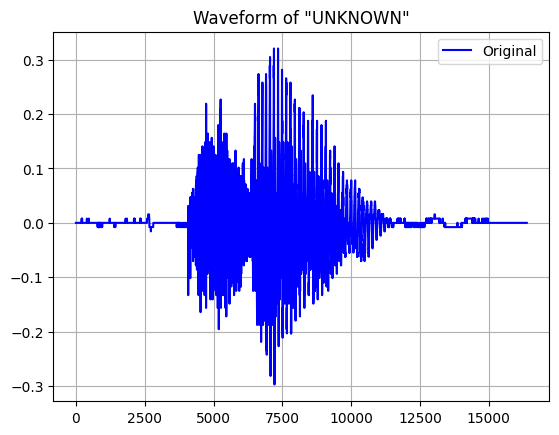

In [5]:
sample_index = np.random.randint(0,len(test_set))

sample, target = test_set[sample_index]
target = classes[target]
print(f'target: {target}, sample index: {sample_index}')

audio_sample = np.array(sample).flatten('F')
plt.plot(audio_sample, color = 'Blue')
plt.legend(['Original'])
plt.title(f'Waveform of "{target}"')
plt.grid()

### Fast Fourier Transform (FFT) for Smoothing the Audio 

FFT is applied to eliminate the noise inside the original data. *psd* is the absolute value to determine a general threshold for smoothing operation. Points under the thresold is set to 0. Inverse transform is applied to go back to the time domain.

In [6]:
def filter_signal(signal):
    
    fourier = np.fft.rfft(signal)
    psd = np.abs(fourier)
    threshold = psd.mean()
    fourier[psd < threshold] = 0
    inv_fft = np.fft.irfft(fourier)

    return np.array(inv_fft, dtype = np.float32)

In [8]:
def snr_mixer2(audio, snr):
    """
    Mix clean and noise with provided SNR level.
    """
    signal_pwr = torch.var(audio)
    snr_linear = torch.tensor(10**(snr / 10), dtype=torch.float32)
    n_var = signal_pwr / snr_linear
    noise = torch.randn(audio.shape) * torch.sqrt(n_var)
    noisy_signal = audio + noise
    max_abs_noise = torch.max(torch.abs(noisy_signal))

    # Normalize the noise tensor
    if max_abs_noise > 1:
        noisy_signal /= max_abs_noise
    return noisy_signal

target: UNKNOWN, sample index: 4945


Text(0.5, 1.0, 'Filtered Noisy Signal')

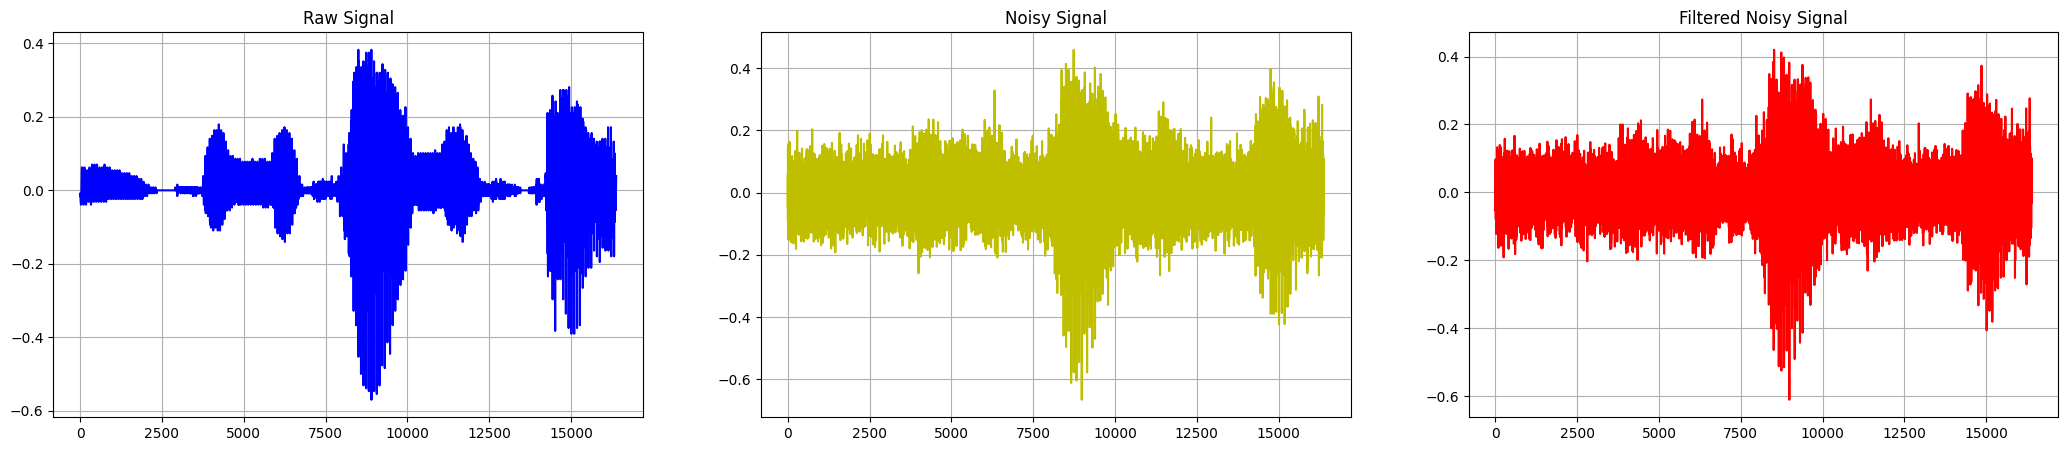

In [40]:
sample_index = np.random.randint(0,len(test_set))

sample, target = test_set[sample_index]
target = classes[target]
print(f'target: {target}, sample index: {sample_index}')

audio_sample = np.array(sample).flatten('F')

noisy_sample = snr_mixer2(sample,1)

noisy_sample = np.array(noisy_sample).flatten('F')

filtered_signal = filter_signal(noisy_sample)


plt.figure(figsize=(35,5))
plt.subplot(1,4,1)
plt.grid()
plt.plot(audio_sample, label='Raw', color = 'blue')
plt.title("Raw Signal")

plt.subplot(1,4,2)
plt.grid()
plt.plot(noisy_sample, label='Noisy', color = 'y')
plt.title("Noisy Signal")

plt.subplot(1,4,3)
plt.grid()
plt.plot(filtered_signal, label='Filtered', color = 'red')
plt.title("Filtered Noisy Signal")

### Start-End Point Detection

Using the smoothed audio file, a dynamic threshold value is chosen to detect the edges of the audio. The reason why I choose a dynamic threshold value is because some of our data is in a wider range according to the other ones. For example some samples are between [-0.2, 0.2] and some are between [-0.8, 0.8]. Of course all of them are in between -1 to 1 but still a global value for threshold can cause problems during augmentation. So the mean of the smoothed signal is chosen for threshold value. 

In [41]:
def energy_detector(audio):

    fft = filter_signal(audio)
    fft_threshold = abs(fft).mean()

    start_pt = np.argmax(abs(fft) > fft_threshold)
    reversed_fft = np.flip(abs(fft))
    end_pt = len(audio) - np.argmax(reversed_fft > fft_threshold)

    return start_pt, end_pt

target: UNKNOWN, sample index: 4360


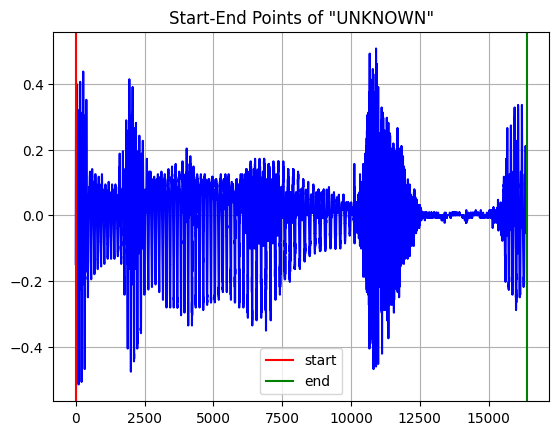

In [112]:
sample_index = np.random.randint(0,len(test_set))

sample, target = test_set[sample_index]
target = classes[target]
print(f'target: {target}, sample index: {sample_index}')

audio_sample = np.array(sample).flatten('F')

start_pt, end_pt = energy_detector(audio_sample)

plt.figure()
plt.plot(audio_sample, color = 'blue')
plt.grid()
plt.title(f'Start-End Points of "{target}"')
plt.axvline(x = start_pt, color = 'red', label = 'start')
plt.axvline(x = end_pt, color = 'g', label = 'end')
plt.legend()

cropped audio file

In [110]:
filtered_signal = audio_sample[start_pt:end_pt]
write('/home/emretopcu/ai8x-training/notebooks/test.wav', 16384, filtered_signal)
IPython.display.Audio('/home/emretopcu/ai8x-training/notebooks/test.wav', rate = 16384)

original audio file

In [111]:
write('/home/emretopcu/ai8x-training/notebooks/test.wav', 16384, audio_sample)
IPython.display.Audio('/home/emretopcu/ai8x-training/notebooks/test.wav', rate = 16384)

## Designing Augmentation Functions for Improved Shifting

### Strech 

Strech function enlarges or shrinks the coming audio file. This may cause loss of information. To avoid this problem according to the edges, audio is shifted left as much as possible. This will help to reduce the amount of the information we may loose during shifting. 

*In kws20.py, this stretch function is not implemented.*

In [113]:
def strech(audio, fs, random_strech_coeff):

    output_len = 16384

    audio = tsm.wsola(audio, random_strech_coeff)
    start_pt, end_pt = energy_detector(audio)

    if end_pt >= output_len:
        missed_length = len(audio) - end_pt

        if start_pt >= missed_length:
            shift_coeff = (-1) * start_pt/fs      #left shift
            audio = KWS.shift(audio, shift_coeff, fs)

    if audio.size >= output_len:
        audio = audio[:output_len]
    else:
        audio = np.pad(audio, [0, output_len - audio.size])
            
    return audio

### Shift

Shifting must be done after detecting the edge points of the audio file in order to avoid distortion of the sample. Shifting coefficient is determined using the start and end points. Our method is circular shift so we have to determine not only the start point, but also the end point.

In [114]:
fs = 16000

min_strech = 0.8
max_strech = 1.3

min_noise = 0
max_noise = 1

- Stretch-Shifting-Noise is applied in this order.

Text(0.5, 1.0, 'Augmented Audio Waveform')

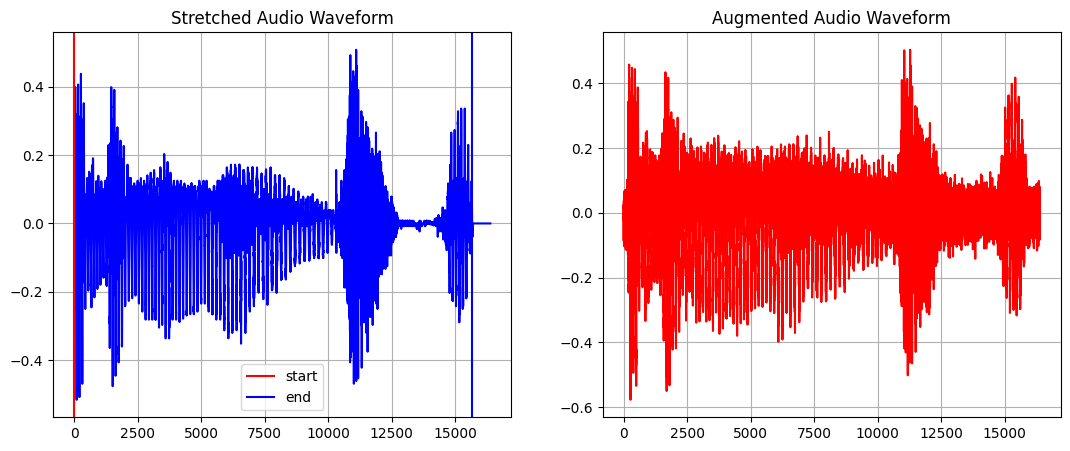

In [116]:
random_noise_var_coeff = np.random.uniform(min_noise, max_noise)
random_strech_coeff = np.random.uniform(min_strech, max_strech)

aug_audio_strech = strech(audio_sample, fs, random_strech_coeff)

start_pt, end_pt = energy_detector(aug_audio_strech)

min_shift = (-1) * (start_pt / fs)
max_shift = (len(audio_sample) - end_pt) / fs

random_shift_time = np.random.uniform(min_shift, max_shift)

aug_audio_shift = KWS.shift(aug_audio_strech, random_shift_time, fs)
aug_audio_noise = KWS.add_white_noise(aug_audio_shift, random_noise_var_coeff)

plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
plt.plot(aug_audio_strech, color = 'blue' )
plt.axvline(x = start_pt, color = 'red', label = 'start')
plt.axvline(x = end_pt, color = 'blue', label = 'end')
plt.grid()
plt.title('Stretched Audio Waveform')
plt.legend()
plt.subplot(1,2,2)
plt.plot(aug_audio_noise, color = 'red' )
plt.grid()
plt.title('Augmented Audio Waveform')

## Testing the Improved Data Loader Using Energy-Detector 

target: three, sample index: 10631


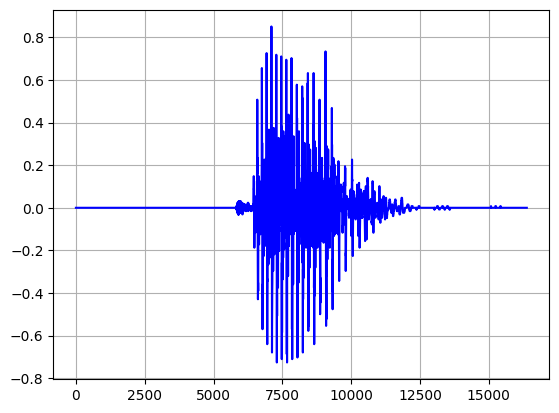

In [118]:
sample_index = np.random.randint(0,len(test_set))

sample, target = test_set[sample_index]
target = classes[target]
print(f'target: {target}, sample index: {sample_index}')

audio_sample = np.array(sample).flatten('F')
plt.plot(audio_sample, color = 'blue')
plt.grid()

- Augmentations are applied separately.

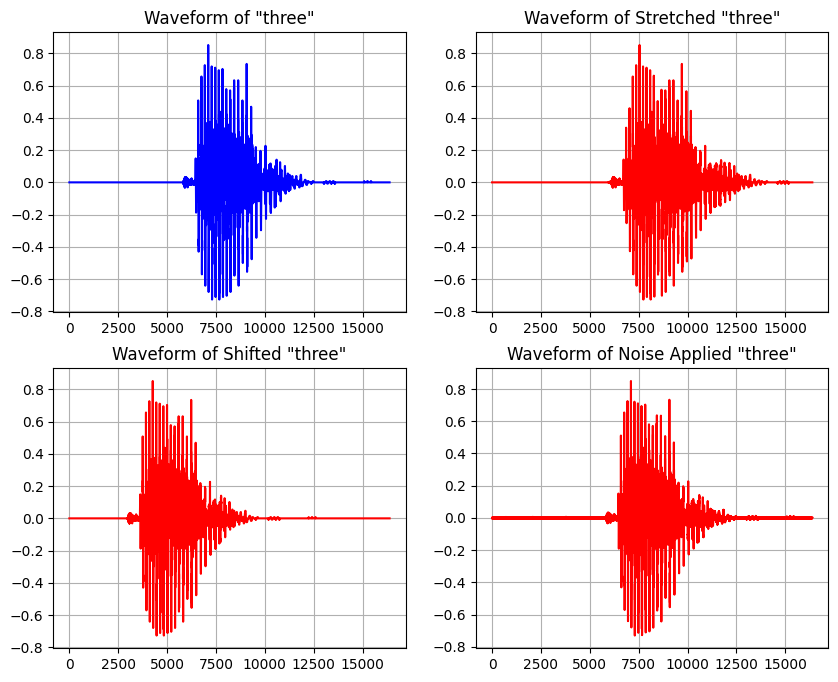

In [119]:
random_noise_var_coeff = np.random.uniform(min_noise, max_noise)
random_strech_coeff = np.random.uniform(min_strech, max_strech)

aug_audio_strech = strech(audio_sample, fs, random_strech_coeff)

start_pt, end_pt = energy_detector(aug_audio_strech)

min_shift = (-1) * (start_pt / fs)
max_shift = (len(audio_sample) - end_pt) / fs

random_shift_time = np.random.uniform(min_shift, max_shift)

aug_audio_shift = KWS.shift(audio_sample, random_shift_time, fs)
aug_audio_noise = KWS.add_white_noise(audio_sample, random_noise_var_coeff)

plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.title(f'Waveform of "{target}"')
plt.grid()
plt.plot(audio_sample, color = 'blue')
plt.subplot(2,2,2)
plt.title(f'Waveform of Stretched "{target}"')
plt.grid()
plt.plot(aug_audio_strech, color = 'red')
plt.subplot(2,2,3)
plt.title(f'Waveform of Shifted "{target}"')
plt.grid()
plt.plot(aug_audio_shift, color = 'red')
plt.subplot(2,2,4)
plt.title(f'Waveform of Noise Applied "{target}"')
plt.grid()
plt.plot(aug_audio_noise, color = 'red')

In [27]:
write('/home/merveeyuboglu/Github/ai8x-training/codes/test.wav', 16384, audio_sample)
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/test.wav', rate = 16384)

- Random augmentations for the same sample

Text(0.5, 1.0, 'Waveform of Augmented "three"')

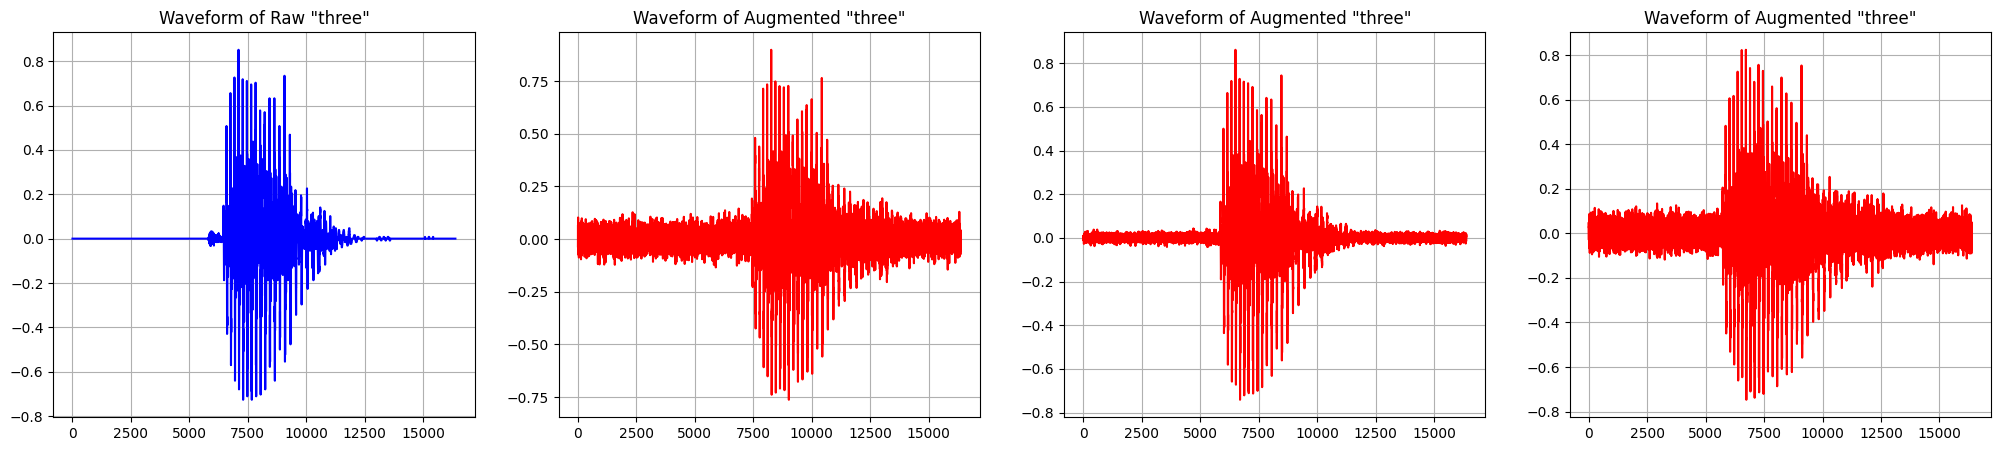

In [120]:
def augment(audio_sample):
    fs = 16000

    min_strech = 0.8
    max_strech = 1.3

    min_noise = 0
    max_noise = 1

    random_noise_var_coeff = np.random.uniform(min_noise, max_noise)
    random_strech_coeff = np.random.uniform(min_strech, max_strech)

    aug_audio_strech = strech(audio_sample, fs, random_strech_coeff)

    start_pt, end_pt = energy_detector(aug_audio_strech)
    min_shift = (-1) * (start_pt / fs)
    max_shift = (len(audio_sample) - end_pt) / fs

    random_shift_time = np.random.uniform(min_shift, max_shift)

    aug_audio_shift = KWS.shift(aug_audio_strech, random_shift_time, fs)
    aug_audio_noise = KWS.add_white_noise(aug_audio_shift, random_noise_var_coeff)
    return aug_audio_noise


audio =  augment(audio_sample)

plt.figure(figsize=(25,5))
plt.subplot(1,4,1)
plt.title(f'Waveform of Raw "{target}"')
plt.grid()
plt.plot(audio_sample, color = 'blue')
plt.subplot(1,4,2)
plt.grid()
plt.plot(audio, color = 'red')
plt.title(f'Waveform of Augmented "{target}"')

audio =  augment(audio_sample)
plt.subplot(1,4,3)
plt.grid()
plt.plot(audio, color = 'red')
plt.title(f'Waveform of Augmented "{target}"')

audio =  augment(audio_sample)
plt.subplot(1,4,4)
plt.grid()
plt.plot(audio, color = 'red')
plt.title(f'Waveform of Augmented "{target}"')


- max & min shift application

Text(0.5, 1.0, 'Waveform of Max Right-Shifted "three"')

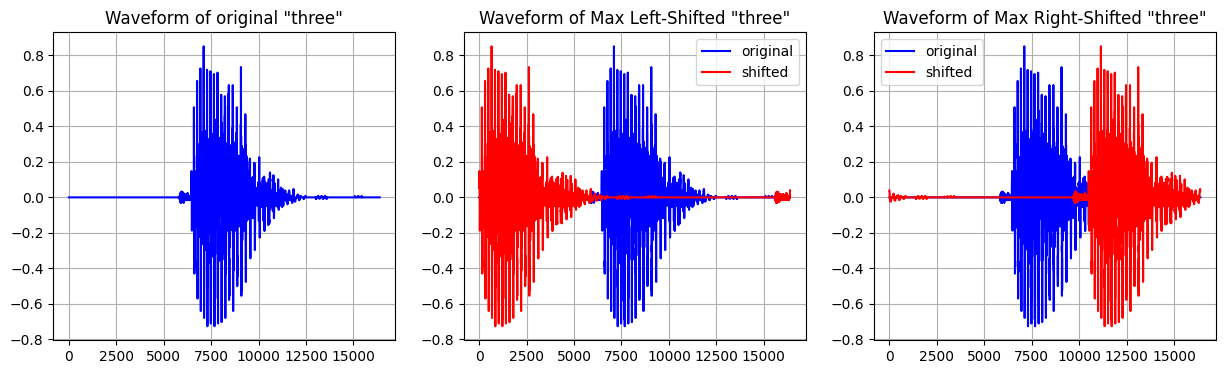

In [121]:
random_strech_coeff = np.random.uniform(min_strech, max_strech)

aug_audio_strech = strech(audio_sample, fs, random_strech_coeff)

start_pt, end_pt = energy_detector(aug_audio_strech)

min_shift = (-1) * (start_pt / fs)
max_shift = (len(audio_sample) - end_pt) / fs

random_shift_time = min_shift
aug_audio_shift = KWS.shift(aug_audio_strech, random_shift_time, fs)

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.grid()
plt.plot(audio_sample, color = 'blue')
plt.title(f'Waveform of original "{target}"')

plt.subplot(1,3,2)
plt.grid()
plt.plot(audio_sample, label= 'original', color = 'blue')
plt.plot(aug_audio_shift,label= 'shifted', color = 'red')
plt.legend()
plt.title(f'Waveform of Max Left-Shifted "{target}"')

plt.subplot(1,3,3)
plt.grid()
random_shift_time = max_shift
aug_audio_shift = KWS.shift(aug_audio_strech, random_shift_time, fs)
plt.plot(audio_sample,label= 'original', color = 'blue')
plt.plot(aug_audio_shift, label= 'shifted',color = 'red')
plt.legend()
plt.title(f'Waveform of Max Right-Shifted "{target}"')